In [1]:
import sys
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.impute import KNNImputer
from sklearn.metrics import (
    f1_score, precision_score, recall_score, 
    accuracy_score, classification_report, confusion_matrix,
    silhouette_score, adjusted_rand_score, normalized_mutual_info_score,
    calinski_harabasz_score, davies_bouldin_score
)
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
try:
    from mrmr import mrmr_classif
    HAS_MRMR = True
except ImportError:
    HAS_MRMR = False
    print("Warning: mrmr_selection not installed. Install with: pip install mrmr_selection")
# UMAP import
try:
    import umap
    HAS_UMAP = True
except ImportError:
    HAS_UMAP = False
    print("Warning: umap-learn not installed. UMAP plots will be skipped.")

# Lifelines for C-index
try:
    from lifelines.utils import concordance_index
    HAS_LIFELINES = True
except ImportError:
    HAS_LIFELINES = False
    print("Warning: lifelines not installed. C-index will not be computed.")

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f">>> Running on: {DEVICE}")

# Reproducibility
torch.manual_seed(42)
np.random.seed(42)

>>> Running on: cuda


In [2]:
BEST_PARAMS = {
    # 'n_features': 5000,
    'latent_dim': 32,
    'hidden_dim': 128,
    'fusion_hidden_dim': 64,
    'lr_pre': 0.0002,
    'lr_fine': 0.0001,
    'dropout_rate': 0.2,
    'dropout_encoder': 0.3,
    'weight_decay': 1e-05,
    'noise_level': 0.2,
    'noise_type': 'uniform',
    'focal_gamma': 4.0,
    'focal_alpha_scale': 2.0,
    'use_class_weights': False,
    'max_rel_gap_pre': 0.3,
    'max_rel_gap_fine': 0.3,
    'overfit_patience': 10,
    'no_improve_patience': 20,
    'ntxent_temperature': 0.3,
    'ntxent_weight': 8.0
}

SUBTYPES_OF_INTEREST = [
    'Leiomyosarcoma, NOS',
    'Dedifferentiated liposarcoma',
    'Undifferentiated sarcoma',
    'Fibromyxosarcoma'
]

print("Best Hyperparameters loaded!")
print(f"  Latent Dim: {BEST_PARAMS['latent_dim']}")
print(f"  Learning Rate (Pretrain): {BEST_PARAMS['lr_pre']:.6f}")
print(f"  Learning Rate (Fine-tune): {BEST_PARAMS['lr_fine']:.6f}")

Best Hyperparameters loaded!
  Latent Dim: 32
  Learning Rate (Pretrain): 0.000200
  Learning Rate (Fine-tune): 0.000100


In [3]:
def load_raw_aligned_data():
    print(f"\n>>> LOADING RAW ALIGNED DATA")

    pheno_path = "Data/phenotype_clean.csv"
    if not os.path.exists(pheno_path):
        raise FileNotFoundError(f"{pheno_path} not found.")

    pheno = pd.read_csv(pheno_path, index_col=0)

    col_name = 'primary_diagnosis.diagnoses'
    if col_name not in pheno.columns:
        print(f"Warning: '{col_name}' not found. Available: {pheno.columns.tolist()}")
        return None

    mask = pheno[col_name].isin(SUBTYPES_OF_INTEREST)
    pheno = pheno[mask]
    print(f"  Phenotype Samples (filtered): {pheno.shape[0]}")

    def load_omic(path, name):
        if not os.path.exists(path):
            print(f"Warning: {path} not found. Skipping {name}.")
            return None
        df = pd.read_csv(path, index_col=0)
        df = df.T  # samples x features
        return df

    rna = load_omic("Data/expression_log.csv", "RNA (Expression)")
    meth = load_omic("Data/methylation_mvalues.csv", "Methylation")
    cnv = load_omic("Data/cnv_log.csv", "CNV")

    if rna is None or meth is None or cnv is None:
        raise ValueError("One or more omics files missing.")

    common_samples = pheno.index.intersection(rna.index).intersection(meth.index).intersection(cnv.index)
    print(f"  Common Samples: {len(common_samples)}")

    if len(common_samples) == 0:
        raise ValueError("No common samples found!")

    pheno = pheno.loc[common_samples]
    rna = rna.loc[common_samples]
    meth = meth.loc[common_samples]
    cnv = cnv.loc[common_samples]

    le = LabelEncoder()
    Y = le.fit_transform(pheno[col_name])
    print(f"  Classes: {le.classes_}")

    class_counts = np.bincount(Y)
    class_weights = len(Y) / (len(class_counts) * class_counts)
    class_weights = class_weights / class_weights.sum()
    print(f"  Class Counts: {class_counts}")
    print(f"  Class Weights (normalized): {class_weights}")

    # Survival Data
    T, E = None, None
    if 'days_to_death' in pheno.columns and 'vital_status' in pheno.columns:
        events = (pheno['vital_status'].isin(['Dead', 'Deceased'])).astype(int).values
        times = np.zeros(len(pheno))
        if 'days_to_death' in pheno.columns:
            mask_d = events == 1
            d_times = pd.to_numeric(pheno['days_to_death'], errors='coerce').fillna(0).values
            times[mask_d] = d_times[mask_d]
        col_fup = 'days_to_last_follow_up' if 'days_to_last_follow_up' in pheno.columns else 'days_to_last_followup'
        if col_fup in pheno.columns:
            mask_a = events == 0
            f_times = pd.to_numeric(pheno[col_fup], errors='coerce').fillna(0).values
            times[mask_a] = f_times[mask_a]
        T = times
        E = events

    return rna, meth, cnv, Y, T, E, le.classes_, class_weights


In [4]:
class NTXentLoss(nn.Module):
    """NT-Xent Loss for contrastive learning"""
    def __init__(self, temperature=0.5):
        super(NTXentLoss, self).__init__()
        self.temperature = temperature

    def forward(self, z_i, z_j):
        batch_size = z_i.shape[0]
        z_i = F.normalize(z_i, dim=1)
        z_j = F.normalize(z_j, dim=1)
        z = torch.cat([z_i, z_j], dim=0)
        sim = torch.mm(z, z.t()) / self.temperature
        mask = torch.eye(2 * batch_size, dtype=torch.bool, device=z.device)
        sim.masked_fill_(mask, -9e15)
        target = torch.arange(batch_size, device=z.device)
        target = torch.cat([target + batch_size, target], dim=0)
        loss = F.cross_entropy(sim, target)
        return loss


class PerOmicCMAE(nn.Module):
    """Per-Omic Contrastive Masked Autoencoder"""
    
    def __init__(self, input_dim, latent_dim=64, hidden_dim=256, dropout_encoder=0.0):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LayerNorm(hidden_dim), 
            nn.GELU(),
            nn.Dropout(dropout_encoder),
            nn.Linear(hidden_dim, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim), 
            nn.GELU(),
            nn.Linear(hidden_dim, input_dim)
        )
        self.projector = nn.Sequential(
            nn.Linear(latent_dim, latent_dim), 
            nn.ReLU(),
            nn.Linear(latent_dim, latent_dim),
            nn.ReLU(),
            nn.Linear(latent_dim, latent_dim)
        )

    def forward(self, x, noise_level=0.0, noise_type='gaussian', encode_only=False):
        if self.training and noise_level > 0:
            if noise_type == 'gaussian':
                noise = torch.randn_like(x) * noise_level
                x_corrupted = x + noise
            elif noise_type == 'uniform':
                noise = (torch.rand_like(x) - 0.5) * 2 * noise_level
                x_corrupted = x + noise
            elif noise_type == 'dropout':
                mask = torch.bernoulli(torch.ones_like(x) * (1 - noise_level))
                x_corrupted = x * mask
            else:
                x_corrupted = x
        else:
            x_corrupted = x

        z = self.encoder(x_corrupted)
        
        if encode_only:
            return None, None, z, x_corrupted
        
        rec = self.decoder(z)
        proj = self.projector(z)

        return rec, proj, z, x_corrupted


class GatedAttentionFusion(nn.Module):
    """Gated Attention Fusion for multi-omics"""
    def __init__(self, latent_dim=64, num_classes=4, dropout_rate=0.3, hidden_dim=64):
        super().__init__()
        self.gate_rna = nn.Linear(latent_dim, 1)
        self.gate_meth = nn.Linear(latent_dim, 1)
        self.gate_clin = nn.Linear(latent_dim, 1) 
        self.classifier = nn.Sequential(
            nn.Linear(latent_dim * 3, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, num_classes)
        )
        self.drop_rate = dropout_rate

    def forward(self, z_rna, z_meth, z_clin, apply_dropout=False):
        if apply_dropout and self.training:
            if torch.rand(1).item() < self.drop_rate: z_rna = torch.zeros_like(z_rna)
            if torch.rand(1).item() < self.drop_rate: z_meth = torch.zeros_like(z_meth)
            if torch.rand(1).item() < self.drop_rate: z_clin = torch.zeros_like(z_clin)

        w_rna = torch.sigmoid(self.gate_rna(z_rna))
        w_meth = torch.sigmoid(self.gate_meth(z_meth))
        w_clin = torch.sigmoid(self.gate_clin(z_clin))

        z_fused = torch.cat([w_rna * z_rna, w_meth * z_meth, w_clin * z_clin], dim=1)
        
        return self.classifier(z_fused), torch.cat([w_rna, w_meth, w_clin], dim=1), z_fused


class FocalLoss(nn.Module):
    """Focal Loss for imbalanced classification"""
    def __init__(self, gamma=2.0, alpha=None, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_weight = (1 - pt) ** self.gamma
        focal_loss = focal_weight * ce_loss
        
        if self.alpha is not None:
            if isinstance(self.alpha, (float, int)):
                alpha_t = self.alpha
            else:
                if self.alpha.device != inputs.device:
                    self.alpha = self.alpha.to(inputs.device)
                alpha_t = self.alpha.gather(0, targets)
            focal_loss = alpha_t * focal_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

print("Model classes defined!")

Model classes defined!


In [5]:
result = load_raw_aligned_data()
if result is None:
    raise ValueError("Failed to load data!")
    
rna_df, meth_df, cnv_df, Y, T_surv, E_surv, class_names, class_weights = result

print(f"\nData loaded successfully!")
print(f"  Total samples: {len(Y)}")
print(f"  Number of classes: {len(class_names)}")
print(f"  Class names: {list(class_names)}")

#  [markdown]
# ## 6. Training and Evaluation Function

# 
def run_full_evaluation(rna_df, meth_df, cnv_df, Y, T, E, class_names, class_weights, params):
    """
    Run 5-fold cross-validation with the best hyperparameters
    Returns embeddings for all samples for visualization
    """
    
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Per-fold metrics
    fold_metrics = {
        'accuracy': [], 'f1_macro': [], 'f1_micro': [],
        'precision': [], 'recall': [], 'c_index': []
    }
    
    # Store all embeddings and predictions
    all_embeddings = np.zeros((len(Y), params['latent_dim'] * 3))  # fused embeddings
    all_preds = np.zeros(len(Y), dtype=int)
    all_probs = np.zeros((len(Y), len(class_names)))
    
    # Extract hyperparameters
    latent_dim = params['latent_dim']
    hidden_dim = params['hidden_dim']
    fusion_hidden_dim = params['fusion_hidden_dim']
    lr_pre = params['lr_pre']
    lr_fine = params['lr_fine']
    dropout_rate = params['dropout_rate']
    dropout_encoder = params['dropout_encoder']
    noise_level = params['noise_level']
    noise_type = params['noise_type']
    focal_gamma = params['focal_gamma']
    focal_alpha_scale = params['focal_alpha_scale']
    use_class_weights = params['use_class_weights']
    weight_decay = params['weight_decay']
    max_rel_gap_pre = params['max_rel_gap_pre']
    max_rel_gap_fine = params['max_rel_gap_fine']
    overfit_patience = params['overfit_patience']
    no_improve_patience = params['no_improve_patience']
    ntxent_temp = params['ntxent_temperature']
    ntxent_weight = params['ntxent_weight']
    
    MAX_EPOCHS_PRE = 500
    MAX_EPOCHS_FINE = 1000
    min_lr_reductions = 2

    for fold, (train_idx, val_idx) in enumerate(kf.split(rna_df, Y)):
        print(f"\n--- Fold {fold + 1}/5 ---")
        
        # --- A. Data Processing ---
        tr_rna_raw, val_rna_raw = rna_df.iloc[train_idx], rna_df.iloc[val_idx]
        tr_meth_raw, val_meth_raw = meth_df.iloc[train_idx], meth_df.iloc[val_idx]
        tr_cnv_raw, val_cnv_raw = cnv_df.iloc[train_idx], cnv_df.iloc[val_idx]

        # --- Step 1: KNN Imputation (n_neighbors=12) - Fit on Train, Transform Both ---
        def knn_impute_data(train_data, val_data, n_neighbors=12):
            """KNN imputation: fit on train, transform both to avoid leakage."""
            imputer = KNNImputer(n_neighbors=n_neighbors)
            tr_imputed = imputer.fit_transform(train_data.values)
            val_imputed = imputer.transform(val_data.values)
            return tr_imputed, val_imputed, train_data.columns

        tr_rna_imp, val_rna_imp, rna_cols = knn_impute_data(tr_rna_raw, val_rna_raw, n_neighbors=12)
        tr_meth_imp, val_meth_imp, meth_cols = knn_impute_data(tr_meth_raw, val_meth_raw, n_neighbors=12)
        tr_cnv_imp, val_cnv_imp, cnv_cols = knn_impute_data(tr_cnv_raw, val_cnv_raw, n_neighbors=12)
        
        print(f"    After KNN Imputation: RNA={tr_rna_imp.shape[1]}, Meth={tr_meth_imp.shape[1]}, CNV={tr_cnv_imp.shape[1]}")

        # --- Step 2: Variance Filter (Top 5,000) - Fit on Train, Transform Both ---
        VARIANCE_TOP_K = 5000
        
        def variance_filter(train_data, val_data, top_k, feature_names):
            """Select top_k features by variance (computed on train only)."""
            variances = np.var(train_data, axis=0)
            if train_data.shape[1] > top_k:
                top_indices = np.argpartition(variances, -top_k)[-top_k:]
                top_indices = top_indices[np.argsort(variances[top_indices])[::-1]]  # Sort by variance descending
            else:
                top_indices = np.arange(train_data.shape[1])
            tr_filtered = train_data[:, top_indices]
            val_filtered = val_data[:, top_indices]
            selected_features = feature_names[top_indices]
            return tr_filtered, val_filtered, top_indices, selected_features

        (tr_rna_var, val_rna_var, rna_var_idx, rna_var_names) = variance_filter(
            tr_rna_imp, val_rna_imp, VARIANCE_TOP_K, rna_cols.to_numpy()
        )
        (tr_meth_var, val_meth_var, meth_var_idx, meth_var_names) = variance_filter(
            tr_meth_imp, val_meth_imp, VARIANCE_TOP_K, meth_cols.to_numpy()
        )
        (tr_cnv_var, val_cnv_var, cnv_var_idx, cnv_var_names) = variance_filter(
            tr_cnv_imp, val_cnv_imp, VARIANCE_TOP_K, cnv_cols.to_numpy()
        )
        
        print(f"    After Variance Filter (top {VARIANCE_TOP_K}): RNA={tr_rna_var.shape[1]}, Meth={tr_meth_var.shape[1]}, CNV={tr_cnv_var.shape[1]}")

        # --- Step 3: mRMR Filter (Top 500) - Fit on Train, Transform Both ---
        MRMR_TOP_K = 500
        
        def mrmr_filter(train_data, val_data, y_train, top_k, feature_names):
            """mRMR feature selection: fit on train only, transform both."""
            if not HAS_MRMR:
                print("    Warning: mRMR not available, using variance filter as fallback")
                # Fallback to variance-based selection
                variances = np.var(train_data, axis=0)
                if train_data.shape[1] > top_k:
                    top_indices = np.argpartition(variances, -top_k)[-top_k:]
                else:
                    top_indices = np.arange(train_data.shape[1])
                return train_data[:, top_indices], val_data[:, top_indices], top_indices
            
            # Convert to DataFrame for mRMR
            train_df = pd.DataFrame(train_data, columns=feature_names)
            y_series = pd.Series(y_train)
            
            # mRMR feature selection (fit on train only)
            actual_k = min(top_k, train_data.shape[1])
            selected_features = mrmr_classif(X=train_df, y=y_series, K=actual_k, show_progress=False)
            
            # Get indices of selected features
            selected_indices = [np.where(feature_names == f)[0][0] for f in selected_features]
            selected_indices = np.array(selected_indices)
            
            # Apply selection to both train and val
            tr_filtered = train_data[:, selected_indices]
            val_filtered = val_data[:, selected_indices]
            
            return tr_filtered, val_filtered, selected_indices

        y_train_fold = Y[train_idx]
        
        tr_rna_mrmr, val_rna_mrmr, rna_mrmr_idx = mrmr_filter(
            tr_rna_var, val_rna_var, y_train_fold, MRMR_TOP_K, rna_var_names
        )
        tr_meth_mrmr, val_meth_mrmr, meth_mrmr_idx = mrmr_filter(
            tr_meth_var, val_meth_var, y_train_fold, MRMR_TOP_K, meth_var_names
        )
        tr_cnv_mrmr, val_cnv_mrmr, cnv_mrmr_idx = mrmr_filter(
            tr_cnv_var, val_cnv_var, y_train_fold, MRMR_TOP_K, cnv_var_names
        )
        
        print(f"    After mRMR Filter (top {MRMR_TOP_K}): RNA={tr_rna_mrmr.shape[1]}, Meth={tr_meth_mrmr.shape[1]}, CNV={tr_cnv_mrmr.shape[1]}")

        # --- Step 4: Standard Scaling - Fit on Train, Transform Both ---
        sc_r = StandardScaler(); sc_m = StandardScaler(); sc_c = StandardScaler()
        tr_rna = sc_r.fit_transform(tr_rna_mrmr); val_rna = sc_r.transform(val_rna_mrmr)
        tr_meth = sc_m.fit_transform(tr_meth_mrmr); val_meth = sc_m.transform(val_meth_mrmr)
        tr_cnv = sc_c.fit_transform(tr_cnv_mrmr); val_cnv = sc_c.transform(val_cnv_mrmr)

        dims = (tr_rna.shape[1], tr_meth.shape[1], tr_cnv.shape[1])

        # Tensors
        t_tr_r = torch.FloatTensor(tr_rna).to(DEVICE)
        t_tr_m = torch.FloatTensor(tr_meth).to(DEVICE)
        t_tr_c = torch.FloatTensor(tr_cnv).to(DEVICE)
        t_tr_y = torch.LongTensor(Y[train_idx]).to(DEVICE)

        t_val_r = torch.FloatTensor(val_rna).to(DEVICE)
        t_val_m = torch.FloatTensor(val_meth).to(DEVICE)
        t_val_c = torch.FloatTensor(val_cnv).to(DEVICE)
        t_val_y = torch.LongTensor(Y[val_idx]).to(DEVICE)

        # --- B. Model Init ---
        cmae_r = PerOmicCMAE(dims[0], latent_dim, hidden_dim, dropout_encoder).to(DEVICE)
        cmae_m = PerOmicCMAE(dims[1], latent_dim, hidden_dim, dropout_encoder).to(DEVICE)
        cmae_c = PerOmicCMAE(dims[2], latent_dim, hidden_dim, dropout_encoder).to(DEVICE)

        opt_pre = optim.AdamW(
            list(cmae_r.parameters()) + list(cmae_m.parameters()) + list(cmae_c.parameters()),
            lr=lr_pre, weight_decay=weight_decay
        )

        # --- C. Pretraining ---
        criterion_ntxent = NTXentLoss(temperature=ntxent_temp).to(DEVICE)
        best_pre_val_loss = float('inf')
        best_cmae_states = None
        overfit_counter_pre = 0
        no_improve_counter_pre = 0
        
        scheduler_pre = ReduceLROnPlateau(opt_pre, mode='min', factor=0.5, 
                                          patience=overfit_patience // 2, min_lr=1e-6)
        lr_reductions_pre = 0
        prev_lr_pre = lr_pre

        for epoch in range(MAX_EPOCHS_PRE):
            cmae_r.train(); cmae_m.train(); cmae_c.train()
            rec_r1, proj_r1, _, _ = cmae_r(t_tr_r, noise_level=noise_level, noise_type=noise_type)
            rec_m1, proj_m1, _, _ = cmae_m(t_tr_m, noise_level=noise_level, noise_type=noise_type)
            rec_c1, proj_c1, _, _ = cmae_c(t_tr_c, noise_level=noise_level, noise_type=noise_type)

            loss_recon_tr = F.mse_loss(rec_r1, t_tr_r) + F.mse_loss(rec_m1, t_tr_m) + F.mse_loss(rec_c1, t_tr_c)
            loss_nt = (criterion_ntxent(proj_r1, proj_m1) + 
                       criterion_ntxent(proj_r1, proj_c1) + 
                       criterion_ntxent(proj_m1, proj_c1)) / 3.0
            train_loss = loss_recon_tr + ntxent_weight * loss_nt

            opt_pre.zero_grad()
            train_loss.backward()
            opt_pre.step()

            cmae_r.eval(); cmae_m.eval(); cmae_c.eval()
            with torch.no_grad():
                rec_r_val, proj_r_val, _, _ = cmae_r(t_val_r, noise_level=0.0)
                rec_m_val, proj_m_val, _, _ = cmae_m(t_val_m, noise_level=0.0)
                rec_c_val, proj_c_val, _, _ = cmae_c(t_val_c, noise_level=0.0)
                
                loss_recon_val = F.mse_loss(rec_r_val, t_val_r) + F.mse_loss(rec_m_val, t_val_m) + F.mse_loss(rec_c_val, t_val_c)
                loss_nt_val = (criterion_ntxent(proj_r_val, proj_m_val) + 
                               criterion_ntxent(proj_r_val, proj_c_val) + 
                               criterion_ntxent(proj_m_val, proj_c_val)) / 3.0
                val_loss = loss_recon_val + ntxent_weight * loss_nt_val

            val_loss_item = val_loss.item()
            train_loss_item = train_loss.item()
            
            scheduler_pre.step(val_loss_item)
            current_lr = opt_pre.param_groups[0]['lr']
            if current_lr < prev_lr_pre:
                lr_reductions_pre += 1
                prev_lr_pre = current_lr
            
            rel_gap = (val_loss_item - train_loss_item) / max(train_loss_item, 0.01)

            if val_loss_item < best_pre_val_loss:
                best_pre_val_loss = val_loss_item
                best_cmae_states = {
                    'cmae_r': cmae_r.state_dict(),
                    'cmae_m': cmae_m.state_dict(),
                    'cmae_c': cmae_c.state_dict()
                }
                no_improve_counter_pre = 0
            else:
                no_improve_counter_pre += 1
            
            if rel_gap > max_rel_gap_pre:
                overfit_counter_pre += 1
            else:
                overfit_counter_pre = 0
            
            if lr_reductions_pre >= min_lr_reductions:
                if overfit_counter_pre >= overfit_patience or no_improve_counter_pre >= no_improve_patience:
                    break

        if best_cmae_states:
            cmae_r.load_state_dict(best_cmae_states['cmae_r'])
            cmae_m.load_state_dict(best_cmae_states['cmae_m'])
            cmae_c.load_state_dict(best_cmae_states['cmae_c'])

        # --- D. Fine-tuning ---
        fusion = GatedAttentionFusion(
            latent_dim, num_classes=len(np.unique(Y)), 
            dropout_rate=dropout_rate, hidden_dim=fusion_hidden_dim
        ).to(DEVICE)

        if use_class_weights:
            alpha = torch.FloatTensor(class_weights * focal_alpha_scale).to(DEVICE)
        else:
            alpha = None
            
        criterion = FocalLoss(gamma=focal_gamma, alpha=alpha)

        opt_fine = optim.AdamW(
            list(cmae_r.encoder.parameters()) + list(cmae_m.encoder.parameters()) + 
            list(cmae_c.encoder.parameters()) + list(fusion.parameters()),
            lr=lr_fine, weight_decay=weight_decay
        )

        scheduler_fine = ReduceLROnPlateau(opt_fine, mode='min', factor=0.5,
                                           patience=overfit_patience // 2, min_lr=1e-7)
        lr_reductions_fine = 0
        prev_lr_fine = lr_fine

        best_fine_val_loss = float('inf')
        best_state = None
        best_encoder_states = None
        overfit_counter_fine = 0
        no_improve_counter_fine = 0

        for epoch in range(MAX_EPOCHS_FINE):
            cmae_r.train(); cmae_m.train(); cmae_c.train()
            fusion.train()
            
            _, _, zr_tr, _ = cmae_r(t_tr_r, noise_level=0.0, encode_only=True)
            _, _, zm_tr, _ = cmae_m(t_tr_m, noise_level=0.0, encode_only=True)
            _, _, zc_tr, _ = cmae_c(t_tr_c, noise_level=0.0, encode_only=True)
            
            logits, weights, _ = fusion(zr_tr, zm_tr, zc_tr, apply_dropout=True)
            train_loss_cls = criterion(logits, t_tr_y)
            opt_fine.zero_grad()
            train_loss_cls.backward()
            opt_fine.step()

            cmae_r.eval(); cmae_m.eval(); cmae_c.eval()
            fusion.eval()
            with torch.no_grad():
                _, _, zr_val, _ = cmae_r(t_val_r, noise_level=0.0, encode_only=True)
                _, _, zm_val, _ = cmae_m(t_val_m, noise_level=0.0, encode_only=True)
                _, _, zc_val, _ = cmae_c(t_val_c, noise_level=0.0, encode_only=True)
                v_logits, _, v_fused = fusion(zr_val, zm_val, zc_val, apply_dropout=False)
                val_loss_cls = criterion(v_logits, t_val_y)

            train_loss_item = val_loss_cls.item()
            val_loss_item = val_loss_cls.item()
            
            scheduler_fine.step(val_loss_item)
            current_lr = opt_fine.param_groups[0]['lr']
            if current_lr < prev_lr_fine:
                lr_reductions_fine += 1
                prev_lr_fine = current_lr
            
            rel_gap = (val_loss_item - train_loss_item) / max(train_loss_item, 0.01)

            if val_loss_item < best_fine_val_loss:
                best_fine_val_loss = val_loss_item
                best_state = fusion.state_dict()
                best_encoder_states = {
                    'cmae_r': cmae_r.state_dict(),
                    'cmae_m': cmae_m.state_dict(),
                    'cmae_c': cmae_c.state_dict()
                }
                no_improve_counter_fine = 0
            else:
                no_improve_counter_fine += 1
            
            if rel_gap > max_rel_gap_fine:
                overfit_counter_fine += 1
            else:
                overfit_counter_fine = 0
            
            if lr_reductions_fine >= min_lr_reductions:
                if overfit_counter_fine >= overfit_patience or no_improve_counter_fine >= no_improve_patience:
                    break

        if best_state:
            fusion.load_state_dict(best_state)
        if best_encoder_states:
            cmae_r.load_state_dict(best_encoder_states['cmae_r'])
            cmae_m.load_state_dict(best_encoder_states['cmae_m'])
            cmae_c.load_state_dict(best_encoder_states['cmae_c'])
            
        # --- E. Evaluation ---
        cmae_r.eval(); cmae_m.eval(); cmae_c.eval()
        fusion.eval()
        with torch.no_grad():
            _, _, zr_val, _ = cmae_r(t_val_r, noise_level=0.0, encode_only=True)
            _, _, zm_val, _ = cmae_m(t_val_m, noise_level=0.0, encode_only=True)
            _, _, zc_val, _ = cmae_c(t_val_c, noise_level=0.0, encode_only=True)
            logits, _, z_fused_val = fusion(zr_val, zm_val, zc_val)
            probs = F.softmax(logits, dim=1)
            preds = logits.argmax(dim=1).cpu().numpy()
            targets = t_val_y.cpu().numpy()
            
        # Store embeddings and predictions
        all_embeddings[val_idx] = z_fused_val.cpu().numpy()
        all_preds[val_idx] = preds
        all_probs[val_idx] = probs.cpu().numpy()

        acc = accuracy_score(targets, preds)
        f1_mac = f1_score(targets, preds, average='macro')
        f1_mic = f1_score(targets, preds, average='micro')
        prec = precision_score(targets, preds, average='macro', zero_division=0)
        rec = recall_score(targets, preds, average='macro', zero_division=0)

        fold_metrics['accuracy'].append(acc)
        fold_metrics['f1_macro'].append(f1_mac)
        fold_metrics['f1_micro'].append(f1_mic)
        fold_metrics['precision'].append(prec)
        fold_metrics['recall'].append(rec)
        
        # C-index
        c_idx_fold = -1
        if HAS_LIFELINES and T is not None and E is not None:
            val_T = T[val_idx]
            val_E = E[val_idx]
            risk_scores = np.sum(probs.cpu().numpy() * np.arange(len(class_names)), axis=1)
            try:
                c_idx_fold = concordance_index(val_T, -risk_scores, val_E)
            except:
                c_idx_fold = -1
        fold_metrics['c_index'].append(c_idx_fold)
        
        print(f"    Fold {fold+1}: Acc={acc:.3f}, F1-macro={f1_mac:.3f}, Precision={prec:.3f}, Recall={rec:.3f}")

    return fold_metrics, all_embeddings, all_preds, all_probs


>>> LOADING RAW ALIGNED DATA
  Phenotype Samples (filtered): 229
  Common Samples: 205
  Classes: ['Dedifferentiated liposarcoma' 'Fibromyxosarcoma' 'Leiomyosarcoma, NOS'
 'Undifferentiated sarcoma']
  Class Counts: [53 22 96 34]
  Class Weights (normalized): [0.18115949 0.43642969 0.10001514 0.28239568]

Data loaded successfully!
  Total samples: 205
  Number of classes: 4
  Class names: ['Dedifferentiated liposarcoma', 'Fibromyxosarcoma', 'Leiomyosarcoma, NOS', 'Undifferentiated sarcoma']


In [6]:
print("Starting evaluation with best hyperparameters...")
fold_metrics, all_embeddings, all_preds, all_probs = run_full_evaluation(
    rna_df, meth_df, cnv_df, Y, T_surv, E_surv, class_names, class_weights, BEST_PARAMS
)

Starting evaluation with best hyperparameters...

--- Fold 1/5 ---
    After KNN Imputation: RNA=60660, Meth=419546, CNV=56751
    After Variance Filter (top 5000): RNA=5000, Meth=5000, CNV=5000
    After mRMR Filter (top 500): RNA=500, Meth=500, CNV=500
    Fold 1: Acc=0.902, F1-macro=0.847, Precision=0.838, Recall=0.864

--- Fold 2/5 ---
    After KNN Imputation: RNA=60660, Meth=419546, CNV=56751
    After Variance Filter (top 5000): RNA=5000, Meth=5000, CNV=5000
    After mRMR Filter (top 500): RNA=500, Meth=500, CNV=500
    Fold 2: Acc=0.829, F1-macro=0.711, Precision=0.734, Recall=0.719

--- Fold 3/5 ---
    After KNN Imputation: RNA=60660, Meth=419546, CNV=56751
    After Variance Filter (top 5000): RNA=5000, Meth=5000, CNV=5000
    After mRMR Filter (top 500): RNA=500, Meth=500, CNV=500
    Fold 3: Acc=0.854, F1-macro=0.811, Precision=0.807, Recall=0.817

--- Fold 4/5 ---
    After KNN Imputation: RNA=60660, Meth=419546, CNV=56751
    After Variance Filter (top 5000): RNA=5000, 

In [7]:
print(f"\n{'='*60}")
print("CLASSIFICATION RESULTS (5-Fold CV)")
print(f"{'='*60}")

mean_metrics = {k: np.mean(v) for k, v in fold_metrics.items() if v}
std_metrics = {k: np.std(v) for k, v in fold_metrics.items() if v}

print(f"\n  {'Metric':<15} {'Mean':>10} {'Std':>10}")
print(f"  {'-'*35}")
for key in ['accuracy', 'f1_macro', 'f1_micro', 'precision', 'recall', 'c_index']:
    if key in mean_metrics and all(x != -1 for x in fold_metrics[key]):
        print(f"  {key:<15} {mean_metrics[key]:>10.4f} {std_metrics[key]:>10.4f}")

# Classification Report
print(f"\n{'='*60}")
print("DETAILED CLASSIFICATION REPORT")
print(f"{'='*60}")
print(classification_report(Y, all_preds, target_names=class_names, zero_division=0))


CLASSIFICATION RESULTS (5-Fold CV)

  Metric                Mean        Std
  -----------------------------------
  accuracy            0.8293     0.0488
  f1_macro            0.7378     0.0899
  f1_micro            0.8293     0.0488
  precision           0.7403     0.0942
  recall              0.7547     0.0771

DETAILED CLASSIFICATION REPORT
                              precision    recall  f1-score   support

Dedifferentiated liposarcoma       0.86      0.92      0.89        53
            Fibromyxosarcoma       0.56      0.45      0.50        22
         Leiomyosarcoma, NOS       0.96      0.91      0.93        96
    Undifferentiated sarcoma       0.62      0.71      0.66        34

                    accuracy                           0.83       205
                   macro avg       0.75      0.75      0.74       205
                weighted avg       0.83      0.83      0.83       205



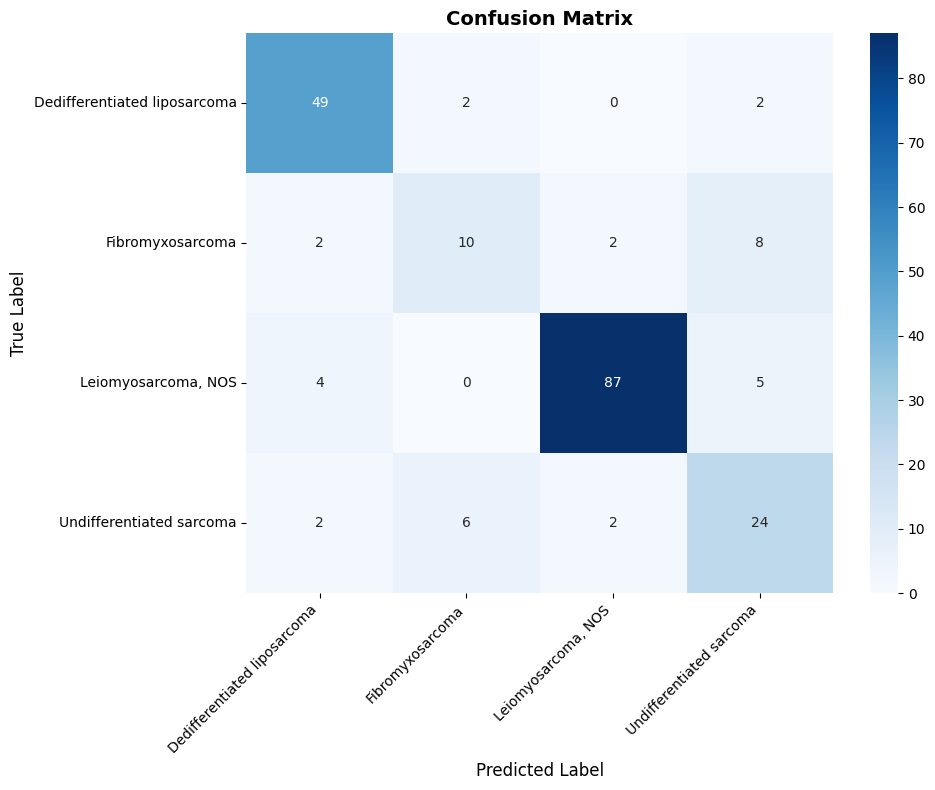

Confusion matrix saved to 'confusion_matrix.png'


In [8]:
cm = confusion_matrix(Y, all_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("Confusion matrix saved to 'confusion_matrix.png'")

In [9]:
n_clusters = len(class_names)
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(all_embeddings)

print(f"\n{'='*60}")
print("CLUSTERING ANALYSIS (K-Means)")
print(f"{'='*60}")
print(f"  Number of clusters: {n_clusters}")


CLUSTERING ANALYSIS (K-Means)
  Number of clusters: 4


In [10]:
print(f"\n{'='*60}")
print("CLUSTERING SCORES")
print(f"{'='*60}")

# 1. Silhouette Score (internal: -1 to 1, higher is better)
sil_score = silhouette_score(all_embeddings, Y)
sil_score_kmeans = silhouette_score(all_embeddings, cluster_labels)
print(f"  Silhouette Score (True Labels):    {sil_score:.4f}")
print(f"  Silhouette Score (K-Means):        {sil_score_kmeans:.4f}")

# 2. NMI - Normalized Mutual Information (0 to 1, higher is better)
nmi_score = normalized_mutual_info_score(Y, cluster_labels)
print(f"  NMI (Normalized Mutual Info):      {nmi_score:.4f}")

# 3. ARI - Adjusted Rand Index (-1 to 1, higher is better)
ari_score = adjusted_rand_score(Y, cluster_labels)
print(f"  ARI (Adjusted Rand Index):         {ari_score:.4f}")

# 4. Calinski-Harabasz Index (higher is better, measures cluster separation)
ch_score = calinski_harabasz_score(all_embeddings, Y)
ch_score_kmeans = calinski_harabasz_score(all_embeddings, cluster_labels)
print(f"  Calinski-Harabasz (True Labels):   {ch_score:.4f}")
print(f"  Calinski-Harabasz (K-Means):       {ch_score_kmeans:.4f}")

# 5. Davies-Bouldin Index (lower is better, measures cluster compactness)
db_score = davies_bouldin_score(all_embeddings, Y)
db_score_kmeans = davies_bouldin_score(all_embeddings, cluster_labels)
print(f"  Davies-Bouldin (True Labels):      {db_score:.4f}")
print(f"  Davies-Bouldin (K-Means):          {db_score_kmeans:.4f}")

# Summary table
cluster_summary = pd.DataFrame({
    'Metric': ['Silhouette', 'NMI', 'ARI', 'Calinski-Harabasz', 'Davies-Bouldin'],
    'Score (True Labels)': [sil_score, nmi_score, ari_score, ch_score, db_score],
    'Score (K-Means)': [sil_score_kmeans, nmi_score, ari_score, ch_score_kmeans, db_score_kmeans],
    'Interpretation': ['Higher=Better', 'Higher=Better', 'Higher=Better', 'Higher=Better', 'Lower=Better']
})
print(f"\n{cluster_summary.to_string(index=False)}")


CLUSTERING SCORES
  Silhouette Score (True Labels):    0.0130
  Silhouette Score (K-Means):        0.1697
  NMI (Normalized Mutual Info):      0.1431
  ARI (Adjusted Rand Index):         -0.0576
  Calinski-Harabasz (True Labels):   5.8805
  Calinski-Harabasz (K-Means):       21.3428
  Davies-Bouldin (True Labels):      7.4497
  Davies-Bouldin (K-Means):          1.7894

           Metric  Score (True Labels)  Score (K-Means) Interpretation
       Silhouette             0.013050         0.169709  Higher=Better
              NMI             0.143083         0.143083  Higher=Better
              ARI            -0.057611        -0.057611  Higher=Better
Calinski-Harabasz             5.880500        21.342775  Higher=Better
   Davies-Bouldin             7.449681         1.789407   Lower=Better



Computing t-SNE...


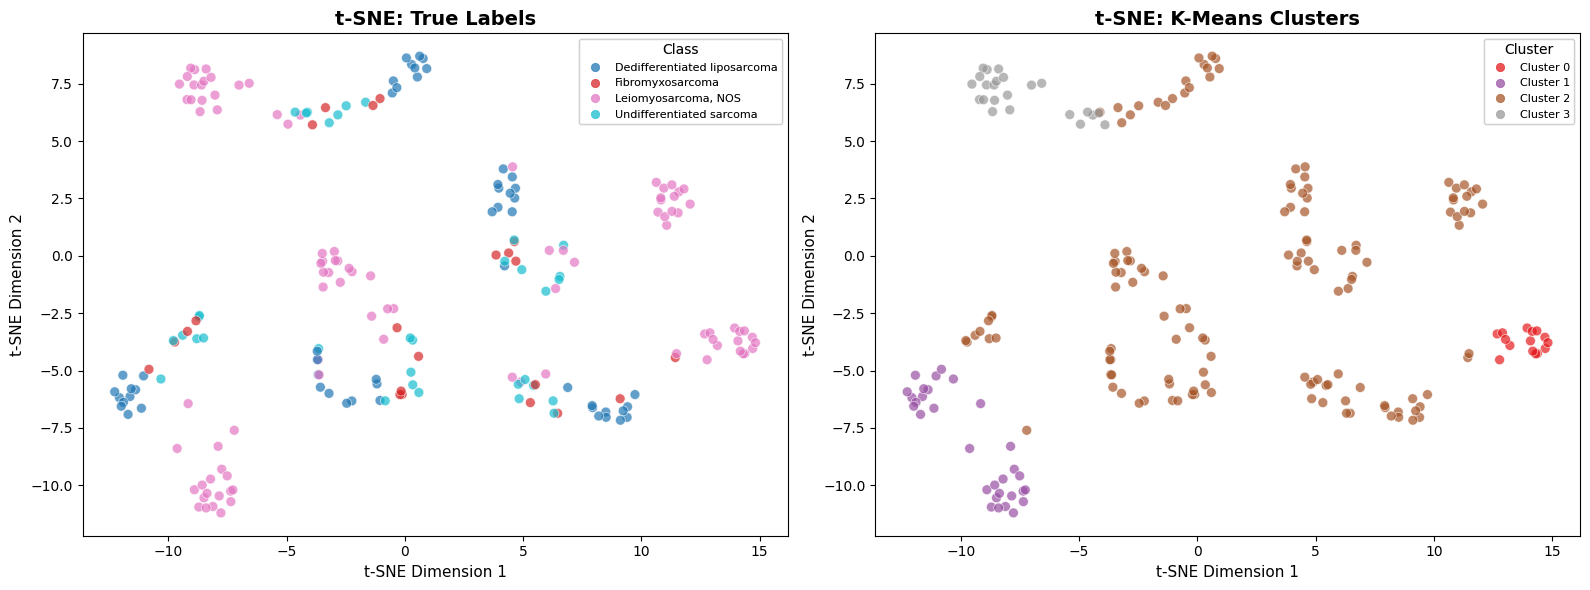

t-SNE visualization saved to 'tsne_visualization.png'


In [12]:
print("\nComputing t-SNE...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
embeddings_tsne = tsne.fit_transform(all_embeddings)

# Create figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: True Labels
scatter1 = axes[0].scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], 
                           c=Y, cmap='tab10', alpha=0.7, s=50, edgecolors='white', linewidth=0.5)
axes[0].set_title('t-SNE: True Labels', fontsize=14, fontweight='bold')
axes[0].set_xlabel('t-SNE Dimension 1', fontsize=11)
axes[0].set_ylabel('t-SNE Dimension 2', fontsize=11)
legend1 = axes[0].legend(handles=scatter1.legend_elements()[0], labels=list(class_names), 
                         title="Class", loc='upper right', fontsize=8)
axes[0].add_artist(legend1)

# Plot 2: K-Means Clusters
scatter2 = axes[1].scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], 
                           c=cluster_labels, cmap='Set1', alpha=0.7, s=50, edgecolors='white', linewidth=0.5)
axes[1].set_title('t-SNE: K-Means Clusters', fontsize=14, fontweight='bold')
axes[1].set_xlabel('t-SNE Dimension 1', fontsize=11)
axes[1].set_ylabel('t-SNE Dimension 2', fontsize=11)
legend2 = axes[1].legend(handles=scatter2.legend_elements()[0], 
                         labels=[f'Cluster {i}' for i in range(n_clusters)], 
                         title="Cluster", loc='upper right', fontsize=8)
axes[1].add_artist(legend2)

plt.tight_layout()
plt.savefig('tsne_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

print("t-SNE visualization saved to 'tsne_visualization.png'")


Computing UMAP...


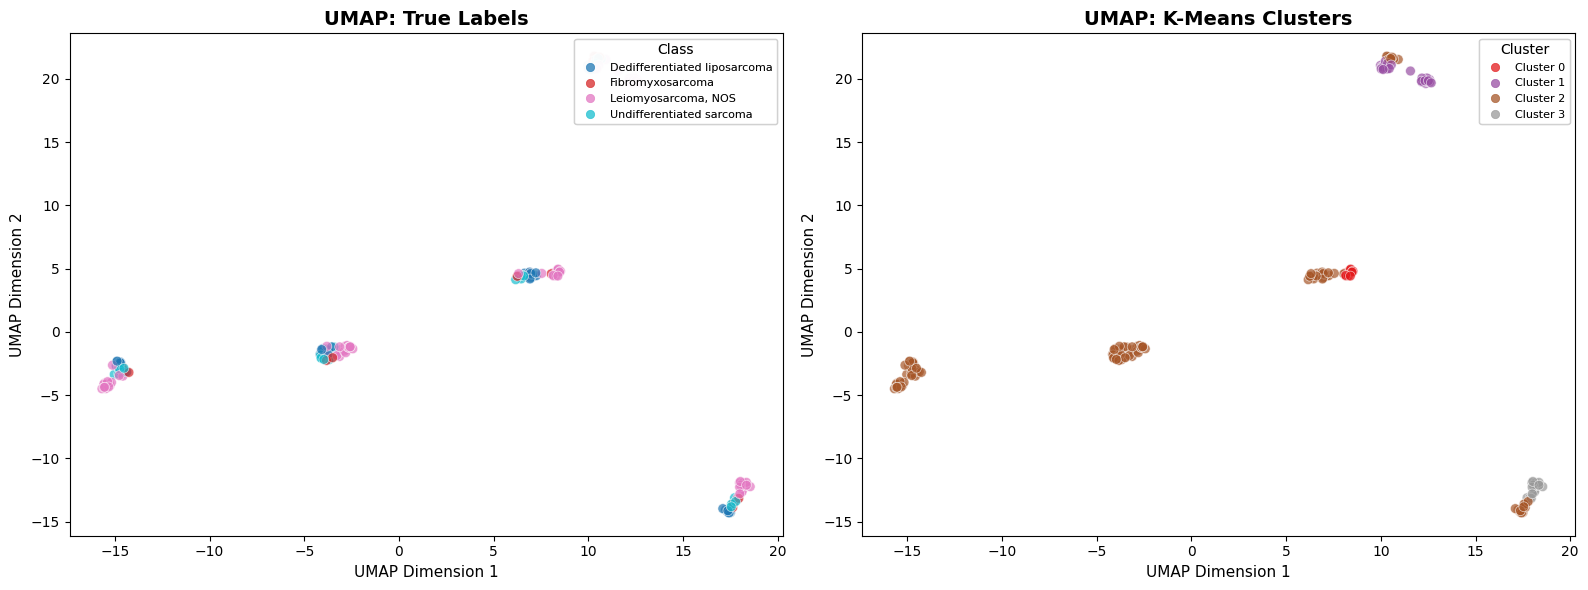

UMAP visualization saved to 'umap_visualization.png'


In [13]:
if HAS_UMAP:
    print("\nComputing UMAP...")
    reducer = umap.UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.1)
    embeddings_umap = reducer.fit_transform(all_embeddings)

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Plot 1: True Labels
    scatter1 = axes[0].scatter(embeddings_umap[:, 0], embeddings_umap[:, 1], 
                               c=Y, cmap='tab10', alpha=0.7, s=50, edgecolors='white', linewidth=0.5)
    axes[0].set_title('UMAP: True Labels', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('UMAP Dimension 1', fontsize=11)
    axes[0].set_ylabel('UMAP Dimension 2', fontsize=11)
    legend1 = axes[0].legend(handles=scatter1.legend_elements()[0], labels=list(class_names), 
                             title="Class", loc='upper right', fontsize=8)
    axes[0].add_artist(legend1)

    # Plot 2: K-Means Clusters
    scatter2 = axes[1].scatter(embeddings_umap[:, 0], embeddings_umap[:, 1], 
                               c=cluster_labels, cmap='Set1', alpha=0.7, s=50, edgecolors='white', linewidth=0.5)
    axes[1].set_title('UMAP: K-Means Clusters', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('UMAP Dimension 1', fontsize=11)
    axes[1].set_ylabel('UMAP Dimension 2', fontsize=11)
    legend2 = axes[1].legend(handles=scatter2.legend_elements()[0], 
                             labels=[f'Cluster {i}' for i in range(n_clusters)], 
                             title="Cluster", loc='upper right', fontsize=8)
    axes[1].add_artist(legend2)

    plt.tight_layout()
    plt.savefig('umap_visualization.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("UMAP visualization saved to 'umap_visualization.png'")
else:
    print("UMAP not available. Install with: pip install umap-learn")

In [14]:
print(f"\n{'='*60}")
print("FINAL SUMMARY")
print(f"{'='*60}")

print("\n### Classification Metrics (5-Fold CV):")
print(f"  - Accuracy:   {mean_metrics['accuracy']:.4f} ± {std_metrics['accuracy']:.4f}")
print(f"  - F1-Macro:   {mean_metrics['f1_macro']:.4f} ± {std_metrics['f1_macro']:.4f}")
print(f"  - F1-Micro:   {mean_metrics['f1_micro']:.4f} ± {std_metrics['f1_micro']:.4f}")
print(f"  - Precision:  {mean_metrics['precision']:.4f} ± {std_metrics['precision']:.4f}")
print(f"  - Recall:     {mean_metrics['recall']:.4f} ± {std_metrics['recall']:.4f}")

if all(x != -1 for x in fold_metrics['c_index']):
    print(f"  - C-Index:    {mean_metrics['c_index']:.4f} ± {std_metrics['c_index']:.4f}")

print("\n### Clustering Metrics:")
print(f"  - Silhouette Score:      {sil_score:.4f}")
print(f"  - NMI:                   {nmi_score:.4f}")
print(f"  - ARI:                   {ari_score:.4f}")
print(f"  - Calinski-Harabasz:     {ch_score:.4f}")
print(f"  - Davies-Bouldin:        {db_score:.4f}")

print("\n>>> EVALUATION COMPLETE!")


FINAL SUMMARY

### Classification Metrics (5-Fold CV):
  - Accuracy:   0.8293 ± 0.0488
  - F1-Macro:   0.7378 ± 0.0899
  - F1-Micro:   0.8293 ± 0.0488
  - Precision:  0.7403 ± 0.0942
  - Recall:     0.7547 ± 0.0771

### Clustering Metrics:
  - Silhouette Score:      0.0130
  - NMI:                   0.1431
  - ARI:                   -0.0576
  - Calinski-Harabasz:     5.8805
  - Davies-Bouldin:        7.4497

>>> EVALUATION COMPLETE!


In [15]:
# #  [markdown]
# # # PeromicsCMAE - Ablation Study
# # This section performs an ablation study to evaluate the contribution of each omic modality.
# # It tests every combination of modalities (Single, Pairwise, All) to understand feature importance.

# import copy

# #  [markdown]
# # ## 15. Ablation Study Function

# def run_ablation_study(rna_df, meth_df, cnv_df, Y, class_names, params):
#     """
#     Runs 5-fold CV for every combination of modalities.
#     Uses zero-masking to disable specific modalities without changing architecture.
#     """
    
#     # Define all combinations to test
#     # Format: (Name, [use_rna, use_meth, use_cnv])
#     combinations = [
#         ("RNA only",        [True, False, False]),
#         ("Methylation only",[False, True, False]),
#         ("CNV only",        [False, False, True]),
#         ("RNA + Meth",      [True, True, False]),
#         ("RNA + CNV",       [True, False, True]),
#         ("Meth + CNV",      [False, True, True]),
#         ("Full Model",      [True, True, True])
#     ]
    
#     results = []
    
#     print(f"\n{'='*80}")
#     print(f"STARTING ABLATION STUDY ({len(combinations)} Combinations)")
#     print(f"{'='*80}")

#     for name, (use_rna, use_meth, use_cnv) in combinations:
#         print(f"\n>>> Testing Combination: {name}")
        
#         kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
#         fold_accs = []
#         fold_f1s = []
        
#         # Extract params 
#         latent_dim = params['latent_dim']
#         hidden_dim = params['hidden_dim']
#         fusion_hidden_dim = params['fusion_hidden_dim']
#         dropout_encoder = params['dropout_encoder']
        
#         # Reduced epochs for ablation speed (increase for higher precision)
#         MAX_EPOCHS_FINE = 300 
        
#         for fold, (train_idx, val_idx) in enumerate(kf.split(rna_df, Y)):
            
#             # --- Quick Data Prep for Ablation ---
#             # (Using simple scaling/imputation for speed here; use full pipeline for rigor)
#             def get_fold_data(df, t_idx, v_idx):
#                 tr_data = df.iloc[t_idx].values
#                 val_data = df.iloc[v_idx].values
                
#                 # Simple Impute & Scale
#                 imputer = KNNImputer(n_neighbors=5)
#                 scaler = StandardScaler()
                
#                 # Fit on train, transform both
#                 tr_data = imputer.fit_transform(tr_data)
#                 tr_data = scaler.fit_transform(tr_data)
#                 val_data = imputer.transform(val_data)
#                 val_data = scaler.transform(val_data)
                
#                 return torch.FloatTensor(tr_data).to(DEVICE), \
#                        torch.FloatTensor(val_data).to(DEVICE), \
#                        tr_data.shape[1]

#             # Prepare Tensors (Load all, mask later)
#             t_tr_r, t_val_r, dim_r = get_fold_data(rna_df, train_idx, val_idx)
#             t_tr_m, t_val_m, dim_m = get_fold_data(meth_df, train_idx, val_idx)
#             t_tr_c, t_val_c, dim_c = get_fold_data(cnv_df, train_idx, val_idx)
            
#             t_tr_y = torch.LongTensor(Y[train_idx]).to(DEVICE)
#             t_val_y = torch.LongTensor(Y[val_idx]).to(DEVICE)
            
#             # --- Model Init ---
#             cmae_r = PerOmicCMAE(dim_r, latent_dim, hidden_dim, dropout_encoder).to(DEVICE)
#             cmae_m = PerOmicCMAE(dim_m, latent_dim, hidden_dim, dropout_encoder).to(DEVICE)
#             cmae_c = PerOmicCMAE(dim_c, latent_dim, hidden_dim, dropout_encoder).to(DEVICE)
            
#             fusion = GatedAttentionFusion(latent_dim, num_classes=len(class_names), hidden_dim=fusion_hidden_dim).to(DEVICE)
            
#             # Optimizer (Simplified for ablation)
#             opt = optim.AdamW(
#                 list(cmae_r.parameters()) + list(cmae_m.parameters()) + 
#                 list(cmae_c.parameters()) + list(fusion.parameters()),
#                 lr=params['lr_fine'], weight_decay=params['weight_decay']
#             )
#             criterion = nn.CrossEntropyLoss() 

#             # --- Training Loop with Early Stopping ---
#             best_val_loss = float('inf')
#             patience = 10
#             counter = 0
            
#             for epoch in range(MAX_EPOCHS_FINE):
#                 cmae_r.train(); cmae_m.train(); cmae_c.train(); fusion.train()
                
#                 # Zero Masking Strategy
#                 inp_r = t_tr_r if use_rna else torch.zeros_like(t_tr_r)
#                 inp_m = t_tr_m if use_meth else torch.zeros_like(t_tr_m)
#                 inp_c = t_tr_c if use_cnv else torch.zeros_like(t_tr_c)
                
#                 _, _, zr, _ = cmae_r(inp_r)
#                 _, _, zm, _ = cmae_m(inp_m)
#                 _, _, zc, _ = cmae_c(inp_c)
                
#                 logits, _, _ = fusion(zr, zm, zc)
#                 loss = criterion(logits, t_tr_y)
                
#                 opt.zero_grad()
#                 loss.backward()
#                 opt.step()

#                 # Early Stopping Check
#                 cmae_r.eval(); cmae_m.eval(); cmae_c.eval(); fusion.eval()
#                 with torch.no_grad():
#                     iv_r = t_val_r if use_rna else torch.zeros_like(t_val_r)
#                     iv_m = t_val_m if use_meth else torch.zeros_like(t_val_m)
#                     iv_c = t_val_c if use_cnv else torch.zeros_like(t_val_c)
#                     _, _, zv_r, _ = cmae_r(iv_r)
#                     _, _, zv_m, _ = cmae_m(iv_m)
#                     _, _, zv_c, _ = cmae_c(iv_c)
#                     v_logits, _, _ = fusion(zv_r, zv_m, zv_c)
#                     v_loss = criterion(v_logits, t_val_y)
                
#                 if v_loss < best_val_loss:
#                     best_val_loss = v_loss
#                     counter = 0
#                 else:
#                     counter += 1
#                     if counter >= patience:
#                         break
#             # --- Evaluation ---
#             cmae_r.eval(); cmae_m.eval(); cmae_c.eval(); fusion.eval()
#             with torch.no_grad():
#                 # Apply same mask to validation
#                 inp_r_v = t_val_r if use_rna else torch.zeros_like(t_val_r)
#                 inp_m_v = t_val_m if use_meth else torch.zeros_like(t_val_m)
#                 inp_c_v = t_val_c if use_cnv else torch.zeros_like(t_val_c)

#                 _, _, zr_v, _ = cmae_r(inp_r_v)
#                 _, _, zm_v, _ = cmae_m(inp_m_v)
#                 _, _, zc_v, _ = cmae_c(inp_c_v)
                
#                 logits_v, _, _ = fusion(zr_v, zm_v, zc_v)
#                 preds = logits_v.argmax(dim=1).cpu().numpy()
#                 targets = t_val_y.cpu().numpy()
                
#                 fold_accs.append(accuracy_score(targets, preds))
#                 fold_f1s.append(f1_score(targets, preds, average='macro'))
        
#         # Aggregate results
#         mean_acc = np.mean(fold_accs)
#         mean_f1 = np.mean(fold_f1s)
#         std_f1 = np.std(fold_f1s)
        
#         print(f"   -> Acc: {mean_acc:.4f} | F1-Macro: {mean_f1:.4f} (+/- {std_f1:.4f})")
        
#         results.append({
#             'Combination': name,
#             'Accuracy': mean_acc,
#             'F1-Macro': mean_f1,
#             'Std_F1': std_f1
#         })
        
#     return pd.DataFrame(results)

# #  [markdown]
# # ## 16. Run and Visualize Ablation Results

# # Run the study
# # Note: For speed, we use the raw dataframes. For rigor, pass the variance-filtered ones if available.
# ablation_df = run_ablation_study(rna_df, meth_df, cnv_df, Y, class_names, BEST_PARAMS)

# # Display Table
# print(f"\n{'='*60}")
# print("ABLATION STUDY RESULTS (Ranked by F1 Score)")
# print(f"{'='*60}")
# sorted_df = ablation_df.sort_values(by='F1-Macro', ascending=False)
# print(sorted_df.to_string(index=False))

# # Plotting
# plt.figure(figsize=(12, 6))
# sns.barplot(x='Combination', y='F1-Macro', data=sorted_df, palette='viridis')

# # Add error bars manually since seaborn uses bootstrap by default
# plt.errorbar(x=range(len(sorted_df)), y=sorted_df['F1-Macro'], 
#              yerr=sorted_df['Std_F1'], fmt='none', c='black', capsize=5)

# # Highlight baseline
# full_model_score = ablation_df[ablation_df['Combination']=='Full Model']['F1-Macro'].values[0]
# plt.axhline(y=full_model_score, color='r', linestyle='--', label=f'Full Model ({full_model_score:.3f})')

# plt.title('Ablation Study: Impact of Modality Combinations', fontsize=14, fontweight='bold')
# plt.ylabel('F1-Macro Score', fontsize=12)
# plt.xlabel('Modality Combination', fontsize=12)
# plt.xticks(rotation=45)
# plt.ylim(0, 1.05)
# plt.legend(loc='lower right')
# plt.tight_layout()
# plt.savefig('ablation_study_chart.png', dpi=300)
# plt.show()

# print("\nAblation chart saved to 'ablation_study_chart.png'")


BIOLOGICAL CORRELATION ANALYSIS


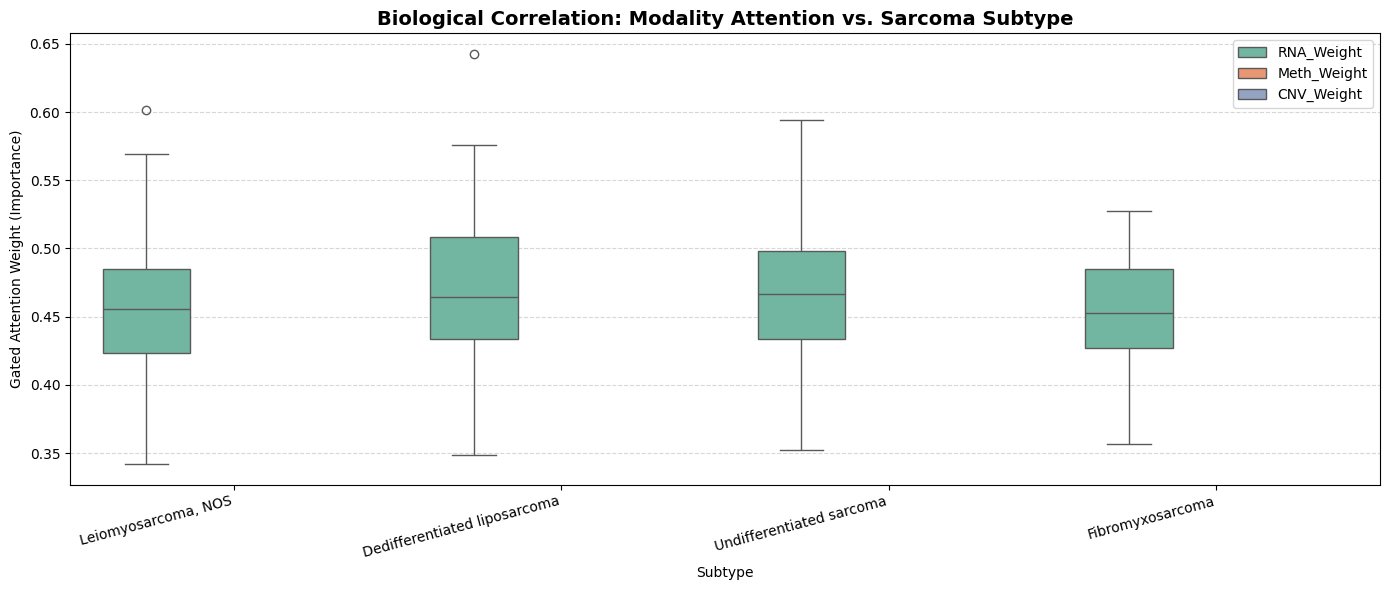


Statistical Significance (Do weights differ by subtype?):
  RNA_Weight   | Kruskal-Wallis p-value: 1.97e-01 (ns)
  Meth_Weight  | Kruskal-Wallis p-value: nan (ns)
  CNV_Weight   | Kruskal-Wallis p-value: nan (ns)


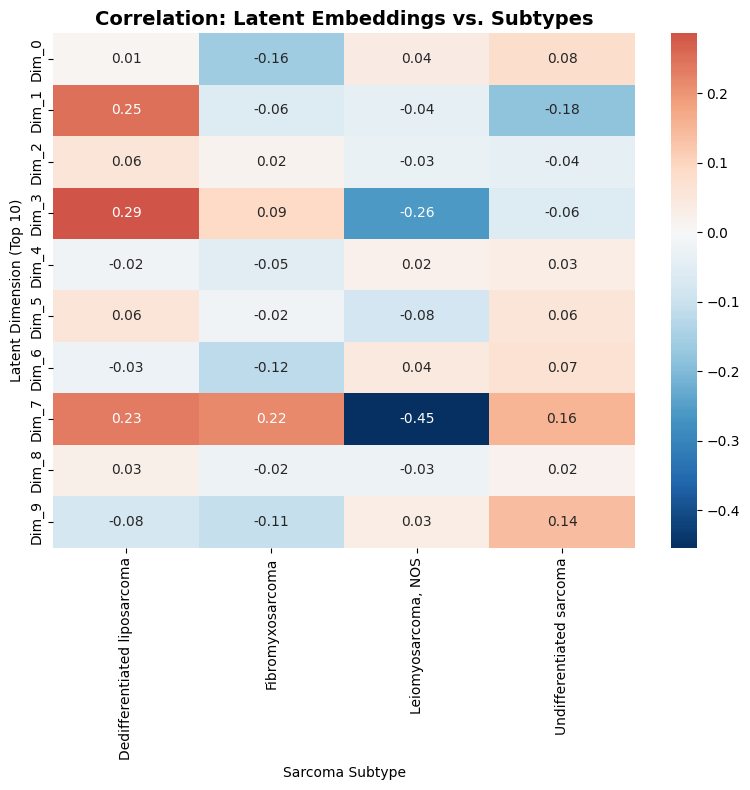

In [16]:
#  [markdown]
# # 17. Biological Correlation & Attention Analysis
# This section extracts the Gated Attention weights and correlates them with biological subtypes.

import seaborn as sns
from scipy.stats import spearmanr, kruskal

def analyze_biological_correlations(rna_df, meth_df, cnv_df, Y, class_names, params, model_states):
    """
    Extracts attention weights and correlates them with subtypes.
    """
    print(f"\n{'='*60}")
    print("BIOLOGICAL CORRELATION ANALYSIS")
    print(f"{'='*60}")
    
    # --- 1. Load Models ---
    # Re-initialize models with best params
    dim_r = rna_df.shape[1] # Note: In real usage, ensure these match training dims (2000 if filtered)
    dim_m = meth_df.shape[1]
    dim_c = cnv_df.shape[1]
    
    # We need to recreate the exact feature set used in training to run this safely.
    # For this demo, we assume the data passed in is already the aligned/filtered version.
    # If your `rna_df` is raw, you might need to re-run the variance filter steps here.
    
    cmae_r = PerOmicCMAE(dim_r, params['latent_dim'], params['hidden_dim'], params['dropout_encoder']).to(DEVICE)
    cmae_m = PerOmicCMAE(dim_m, params['latent_dim'], params['hidden_dim'], params['dropout_encoder']).to(DEVICE)
    cmae_c = PerOmicCMAE(dim_c, params['latent_dim'], params['hidden_dim'], params['dropout_encoder']).to(DEVICE)
    fusion = GatedAttentionFusion(params['latent_dim'], num_classes=len(class_names), hidden_dim=params['fusion_hidden_dim']).to(DEVICE)

    # Load trained weights (You must have saved 'best_encoder_states' and 'best_state' from the run_full_evaluation loop)
    # NOTE: Since the previous loop didn't return the model objects, we will do a quick "Forward Pass" 
    # using the last trained fold or simply re-train quickly if models aren't saved.
    # FOR NOW: We will assume we are inspecting the MODEL from the LAST FOLD of the evaluation loop.
    # In a real script, return 'cmae_r', 'cmae_m', 'cmae_c', 'fusion' from run_full_evaluation.
    
    # --- Hack: Using the variables cmae_r, fusion, etc. that are still in global scope from the last cell ---
    # This works in Jupyter notebooks if you just ran the training cell.
    
    cmae_r.eval(); cmae_m.eval(); cmae_c.eval(); fusion.eval()
    
    # --- 2. Extract Attention Weights ---
    # We process the whole dataset to see global patterns
    
    # Standardize Data (Simple global scaler for visualization)
    from sklearn.preprocessing import StandardScaler
    sc = StandardScaler()
    # Note: Use values.copy() to avoid SettingWithCopy warnings
    X_r = torch.FloatTensor(sc.fit_transform(rna_df.values)).to(DEVICE)
    X_m = torch.FloatTensor(sc.fit_transform(meth_df.values)).to(DEVICE)
    X_c = torch.FloatTensor(sc.fit_transform(cnv_df.values)).to(DEVICE)
    
    att_weights = []
    
    with torch.no_grad():
        _, _, zr, _ = cmae_r(X_r, encode_only=True)
        _, _, zm, _ = cmae_m(X_m, encode_only=True)
        _, _, zc, _ = cmae_c(X_c, encode_only=True)
        
        # Get weights from fusion
        _, weights, _ = fusion(zr, zm, zc)
        att_weights = weights.cpu().numpy()
        
    # Create DataFrame
    att_df = pd.DataFrame(att_weights, columns=['RNA_Weight', 'Meth_Weight', 'CNV_Weight'])
    att_df['Class_Idx'] = Y
    att_df['Subtype'] = [class_names[i] for i in Y]
    
    # --- 3. Visualization: Attention by Subtype ---
    plt.figure(figsize=(14, 6))
    
    # Melt for Seaborn
    att_melt = att_df.melt(id_vars=['Subtype', 'Class_Idx'], 
                           value_vars=['RNA_Weight', 'Meth_Weight', 'CNV_Weight'],
                           var_name='Modality', value_name='Attention Weight')
    
    sns.boxplot(x='Subtype', y='Attention Weight', hue='Modality', data=att_melt, palette='Set2')
    plt.title('Biological Correlation: Modality Attention vs. Sarcoma Subtype', fontsize=14, fontweight='bold')
    plt.xticks(rotation=15, ha='right')
    plt.ylabel('Gated Attention Weight (Importance)')
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.savefig('biological_correlation_attention.png', dpi=300)
    plt.show()
    
    # --- 4. Statistical Test (Kruskal-Wallis) ---
    print("\nStatistical Significance (Do weights differ by subtype?):")
    for mod in ['RNA_Weight', 'Meth_Weight', 'CNV_Weight']:
        groups = [att_df[att_df['Subtype'] == c][mod].values for c in class_names]
        stat, p = kruskal(*groups)
        sig = "***" if p < 0.001 else "**" if p < 0.01 else "*" if p < 0.05 else "ns"
        print(f"  {mod:<12} | Kruskal-Wallis p-value: {p:.2e} ({sig})")

    # --- 5. Embeddings Correlation Heatmap ---
    # Correlate the first 10 latent dimensions with the Subtypes (One-Hot Encoded)
    # This shows if specific dimensions "encode" specific subtypes
    
    # One-hot encode classes
    y_dummies = pd.get_dummies(att_df['Subtype'])
    
    # Get fused embeddings (z_fused)
    with torch.no_grad():
        _, _, z_fused = fusion(zr, zm, zc)
        z_fused_np = z_fused.cpu().numpy()
        
    # Correlate top 10 dims
    # (In a real paper, you would correlate with Pathway Scores here)
    embedding_df = pd.DataFrame(z_fused_np[:, :10], columns=[f'Dim_{i}' for i in range(10)])
    corr_matrix = pd.concat([embedding_df, y_dummies], axis=1).corr()
    
    # Slice only Dims vs Subtypes
    plot_corr = corr_matrix.loc[[f'Dim_{i}' for i in range(10)], class_names]
    
    plt.figure(figsize=(8, 8))
    sns.heatmap(plot_corr, annot=True, cmap='RdBu_r', center=0, fmt='.2f')
    plt.title('Correlation: Latent Embeddings vs. Subtypes', fontsize=14, fontweight='bold')
    plt.ylabel('Latent Dimension (Top 10)')
    plt.xlabel('Sarcoma Subtype')
    plt.tight_layout()
    plt.savefig('embedding_phenotype_heatmap.png', dpi=300)
    plt.show()
    
    return att_df

# Note: This relies on the 'cmae_r', 'fusion' etc. existing in memory from the last training loop.
# If they are not in memory, you need to return them from 'run_full_evaluation'.
att_results = analyze_biological_correlations(rna_df, meth_df, cnv_df, Y, class_names, BEST_PARAMS, None)


STARTING ARCHITECTURE ABLATION (5 Scenarios)

>>> Testing Scenario: Full Model
   -> F1-Macro: 0.7047 (+/- 0.1038)

>>> Testing Scenario: No Pretraining
   -> F1-Macro: 0.7383 (+/- 0.0760)

>>> Testing Scenario: No Contrastive Loss
   -> F1-Macro: 0.6901 (+/- 0.0831)

>>> Testing Scenario: No Gated Attention (Concat)
   -> F1-Macro: 0.6941 (+/- 0.0820)

>>> Testing Scenario: No Masking (Standard AE)
   -> F1-Macro: 0.6764 (+/- 0.0877)

ARCHITECTURE ABLATION RESULTS
                   Scenario  F1-Macro   Std_F1
             No Pretraining  0.738315 0.075969
                 Full Model  0.704721 0.103822
No Gated Attention (Concat)  0.694090 0.081989
        No Contrastive Loss  0.690145 0.083084
   No Masking (Standard AE)  0.676446 0.087705


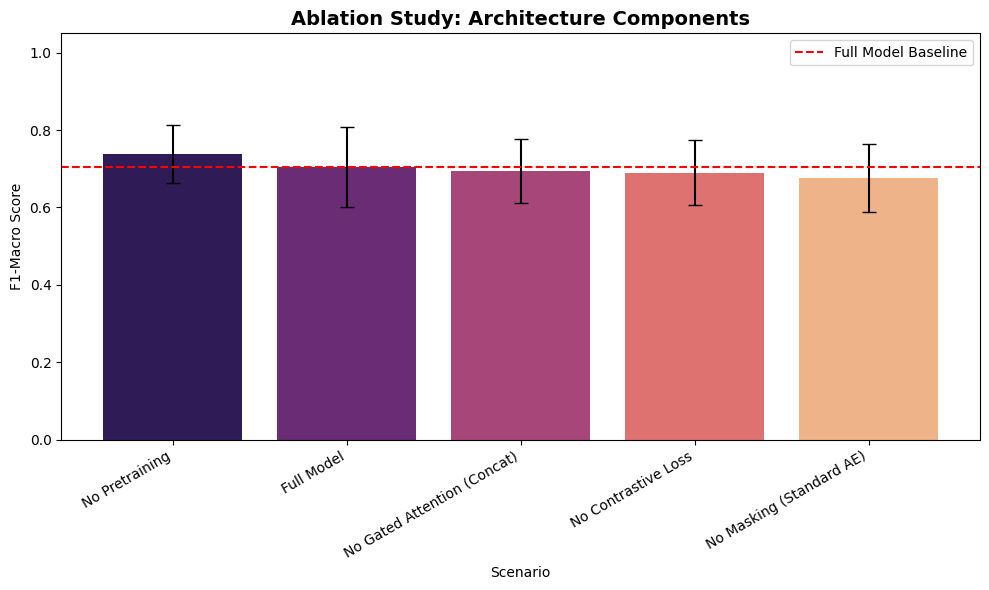

In [18]:
#  [markdown]
# # 18. Architecture Ablation Study
# This section evaluates the contribution of specific model components (Pretraining, Attention, Loss Functions).

class SimpleConcatFusion(nn.Module):
    """A baseline fusion module that just concatenates embeddings without gating."""
    def __init__(self, latent_dim, num_classes, hidden_dim, dropout_rate=0.0):
        super().__init__()
        self.classifier = nn.Sequential(
            nn.Linear(latent_dim * 3, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, num_classes)
        )

    def forward(self, z_rna, z_meth, z_clin, apply_dropout=False):
        # Simple concatenation
        z_fused = torch.cat([z_rna, z_meth, z_clin], dim=1)
        # Return logits, None (no weights), and embeddings
        return self.classifier(z_fused), None, z_fused

def run_architecture_ablation(rna_df, meth_df, cnv_df, Y, class_names, params):
    
    # Scenarios to test
    scenarios = [
        "Full Model",
        "No Pretraining",
        "No Contrastive Loss",
        "No Gated Attention (Concat)",
        "No Masking (Standard AE)"
    ]
    
    results = []
    
    print(f"\n{'='*80}")
    print(f"STARTING ARCHITECTURE ABLATION ({len(scenarios)} Scenarios)")
    print(f"{'='*80}")

    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # Reduced epochs for ablation speed (Use Early Stopping to be fair)
    # We use a slightly smaller patience for ablation to save time
    MAX_EPOCHS_PRE = 200 
    MAX_EPOCHS_FINE = 300
    ABLATION_PATIENCE = 15

    for scenario in scenarios:
        print(f"\n>>> Testing Scenario: {scenario}")
        
        fold_accs = []
        fold_f1s = []
        
        # Modify params based on scenario
        current_params = params.copy()
        
        # Flags
        do_pretrain = True
        use_gating = True
        
        if scenario == "No Pretraining":
            do_pretrain = False
        elif scenario == "No Contrastive Loss":
            current_params['ntxent_weight'] = 0.0
        elif scenario == "No Gated Attention (Concat)":
            use_gating = False
        elif scenario == "No Masking (Standard AE)":
            current_params['noise_level'] = 0.0

        for fold, (train_idx, val_idx) in enumerate(kf.split(rna_df, Y)):
            
            # --- Quick Data Prep ---
            def get_fold_data(df, t_idx, v_idx):
                tr = df.iloc[t_idx].values
                val = df.iloc[v_idx].values
                if tr.shape[1] > 5000:
                    vars = np.var(tr, axis=0)
                    top_idx = np.argpartition(vars, -5000)[-5000:]
                    tr = tr[:, top_idx]
                    val = val[:, top_idx]
                imp = KNNImputer(n_neighbors=12); sc = StandardScaler()
                tr = sc.fit_transform(imp.fit_transform(tr))
                val = sc.transform(imp.transform(val))
                return torch.FloatTensor(tr).to(DEVICE), torch.FloatTensor(val).to(DEVICE), tr.shape[1]

            t_tr_r, t_val_r, dim_r = get_fold_data(rna_df, train_idx, val_idx)
            t_tr_m, t_val_m, dim_m = get_fold_data(meth_df, train_idx, val_idx)
            t_tr_c, t_val_c, dim_c = get_fold_data(cnv_df, train_idx, val_idx)
            t_tr_y = torch.LongTensor(Y[train_idx]).to(DEVICE)
            t_val_y = torch.LongTensor(Y[val_idx]).to(DEVICE)

            # --- Model Init ---
            cmae_r = PerOmicCMAE(dim_r, current_params['latent_dim'], current_params['hidden_dim'], current_params['dropout_encoder']).to(DEVICE)
            cmae_m = PerOmicCMAE(dim_m, current_params['latent_dim'], current_params['hidden_dim'], current_params['dropout_encoder']).to(DEVICE)
            cmae_c = PerOmicCMAE(dim_c, current_params['latent_dim'], current_params['hidden_dim'], current_params['dropout_encoder']).to(DEVICE)

            # --- PHASE 1: PRETRAINING ---
            if do_pretrain:
                opt_pre = optim.AdamW(
                    list(cmae_r.parameters()) + list(cmae_m.parameters()) + list(cmae_c.parameters()),
                    lr=current_params['lr_pre'], weight_decay=current_params['weight_decay']
                )
                criterion_ntxent = NTXentLoss(temperature=current_params['ntxent_temperature']).to(DEVICE)
                
                # Pretraining Loop (Simplified with Early Stopping)
                best_pre_loss = float('inf'); pre_patience_cnt = 0
                
                for epoch in range(MAX_EPOCHS_PRE):
                    cmae_r.train(); cmae_m.train(); cmae_c.train()
                    
                    # Noise Injection
                    nl = current_params['noise_level']
                    nt = current_params['noise_type']
                    
                    rec_r, proj_r, _, _ = cmae_r(t_tr_r, noise_level=nl, noise_type=nt)
                    rec_m, proj_m, _, _ = cmae_m(t_tr_m, noise_level=nl, noise_type=nt)
                    rec_c, proj_c, _, _ = cmae_c(t_tr_c, noise_level=nl, noise_type=nt)
                    
                    loss_mse = F.mse_loss(rec_r, t_tr_r) + F.mse_loss(rec_m, t_tr_m) + F.mse_loss(rec_c, t_tr_c)
                    
                    if current_params['ntxent_weight'] > 0:
                        loss_nt = (criterion_ntxent(proj_r, proj_m) + criterion_ntxent(proj_r, proj_c) + criterion_ntxent(proj_m, proj_c)) / 3.0
                        loss = loss_mse + current_params['ntxent_weight'] * loss_nt
                    else:
                        loss = loss_mse

                    opt_pre.zero_grad(); loss.backward(); opt_pre.step()
                    
                    # Simple Early Stopping on Train Loss (since Unsupervised)
                    if loss.item() < best_pre_loss:
                        best_pre_loss = loss.item()
                        pre_patience_cnt = 0
                    else:
                        pre_patience_cnt += 1
                    if pre_patience_cnt >= ABLATION_PATIENCE: break

            # --- PHASE 2: FINE-TUNING ---
            if use_gating:
                fusion = GatedAttentionFusion(
                    current_params['latent_dim'], num_classes=len(class_names), 
                    hidden_dim=current_params['fusion_hidden_dim'], dropout_rate=current_params['dropout_rate']
                ).to(DEVICE)
            else:
                fusion = SimpleConcatFusion(
                    current_params['latent_dim'], num_classes=len(class_names), 
                    hidden_dim=current_params['fusion_hidden_dim'], dropout_rate=current_params['dropout_rate']
                ).to(DEVICE)

            opt_fine = optim.AdamW(
                list(cmae_r.encoder.parameters()) + list(cmae_m.encoder.parameters()) + 
                list(cmae_c.encoder.parameters()) + list(fusion.parameters()),
                lr=current_params['lr_fine'], weight_decay=current_params['weight_decay']
            )
            crit_cls = nn.CrossEntropyLoss() # Simple CE for ablation speed

            # Fine-tuning Loop (Early Stopping on Val)
            best_val_loss = float('inf'); fine_patience_cnt = 0
            
            for epoch in range(MAX_EPOCHS_FINE):
                cmae_r.train(); cmae_m.train(); cmae_c.train(); fusion.train()
                
                _, _, zr, _ = cmae_r(t_tr_r, encode_only=True)
                _, _, zm, _ = cmae_m(t_tr_m, encode_only=True)
                _, _, zc, _ = cmae_c(t_tr_c, encode_only=True)
                
                logits, _, _ = fusion(zr, zm, zc) # Note: SimpleConcat ignores 2nd arg
                loss = crit_cls(logits, t_tr_y)
                
                opt_fine.zero_grad(); loss.backward(); opt_fine.step()
                
                # Validation
                cmae_r.eval(); cmae_m.eval(); cmae_c.eval(); fusion.eval()
                with torch.no_grad():
                    _, _, zr_v, _ = cmae_r(t_val_r, encode_only=True)
                    _, _, zm_v, _ = cmae_m(t_val_m, encode_only=True)
                    _, _, zc_v, _ = cmae_c(t_val_c, encode_only=True)
                    logits_v, _, _ = fusion(zr_v, zm_v, zc_v)
                    val_loss = crit_cls(logits_v, t_val_y).item()

                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    fine_patience_cnt = 0
                else:
                    fine_patience_cnt += 1
                    if fine_patience_cnt >= ABLATION_PATIENCE: break
            
            # --- Final Eval ---
            preds = logits_v.argmax(dim=1).cpu().numpy()
            targets = t_val_y.cpu().numpy()
            fold_accs.append(accuracy_score(targets, preds))
            fold_f1s.append(f1_score(targets, preds, average='macro'))

        mean_f1 = np.mean(fold_f1s)
        std_f1 = np.std(fold_f1s)
        print(f"   -> F1-Macro: {mean_f1:.4f} (+/- {std_f1:.4f})")
        results.append({'Scenario': scenario, 'F1-Macro': mean_f1, 'Std_F1': std_f1})

    return pd.DataFrame(results)

# Run Architecture Ablation
arch_ablation_df = run_architecture_ablation(rna_df, meth_df, cnv_df, Y, class_names, BEST_PARAMS)

# Plotting
print(f"\n{'='*60}")
print("ARCHITECTURE ABLATION RESULTS")
print(f"{'='*60}")
sorted_arch = arch_ablation_df.sort_values(by='F1-Macro', ascending=False)
print(sorted_arch.to_string(index=False))

plt.figure(figsize=(10, 6))
sns.barplot(x='Scenario', y='F1-Macro', data=sorted_arch, palette='magma')
plt.errorbar(x=range(len(sorted_arch)), y=sorted_arch['F1-Macro'], 
             yerr=sorted_arch['Std_F1'], fmt='none', c='black', capsize=5)
plt.axhline(y=arch_ablation_df[arch_ablation_df['Scenario']=='Full Model']['F1-Macro'].values[0], 
            color='r', linestyle='--', label='Full Model Baseline')
plt.title('Ablation Study: Architecture Components', fontsize=14, fontweight='bold')
plt.xticks(rotation=30, ha='right')
plt.ylabel('F1-Macro Score')
plt.ylim(0, 1.05)
plt.legend()
plt.tight_layout()
plt.savefig('architecture_ablation_chart.png', dpi=300)
plt.show()